In [ ]:
# 03_test_on_holdout.ipynb

# Setup
import os
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import load
from IPython.display import display

RANDOM_STATE = 42
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")

# Saved model files from notebook 02
MODEL_PATHS = {
    "ridge": MODEL_DIR / "02_ridge_pipeline.joblib",
    "lasso": MODEL_DIR / "02_lasso_pipeline.joblib",
    "enet":  MODEL_DIR / "02_enet_pipeline.joblib",
    "random_forest": MODEL_DIR / "02_rf_pipeline.joblib",
    "mlp_es": MODEL_DIR / "02_mlp_es_pipeline.joblib",
}

# Load test set
test_df = pd.read_csv(DATA_DIR / "test.csv")

# Id column
if "Id" in test_df.columns:
    id_col = test_df["Id"].values
else:
    id_col = np.arange(1, len(test_df) + 1)

# Predict helper, models were trained on log1p(SalePrice)
def predict_prices(pipeline, df):
    y_log = pipeline.predict(df)
    y_price = np.expm1(y_log)
    y_price = np.clip(y_price, 1.0, None)
    return y_price

# Load models and predict
predictions = {}
loaded = {}
for name, path in MODEL_PATHS.items():
    if path.exists():
        pipe = load(path)
        loaded[name] = pipe
        preds = predict_prices(pipe, test_df.copy())
        predictions[name] = preds
        print(f"Loaded {name:<13} | {path.name:<28} | preds: {preds.shape}")
    else:
        print(f"Missing model file: {path.name}")

# Simple blends in log space
def blend_log_average(pred_dict, model_names):
    logs = [np.log1p(pred_dict[m]) for m in model_names if m in pred_dict]
    if not logs:
        return None
    avg_log = np.mean(np.vstack(logs), axis=0)
    return np.expm1(avg_log)

blend_specs = {
    "blend_ridge_rf": ["ridge", "random_forest"],
    "blend_ridge_lasso_mlp": ["ridge", "lasso", "mlp_es"],
    "blend_all": list(predictions.keys())
}

# Quick distribution check per model
summary = []
for name, preds in predictions.items():
    s = pd.Series(preds)
    summary.append({
        "model": name,
        "min": float(s.min()),
        "p25": float(s.quantile(0.25)),
        "median": float(s.median()),
        "p75": float(s.quantile(0.75)),
        "max": float(s.max()),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1))
    })

dist_df = pd.DataFrame(summary).sort_values("median")
print("\nPrediction distribution summary")
# dist_df is our summary DataFrame
num_cols = dist_df.select_dtypes(include="number").columns
fmt = {c: "{:,.1f}".format for c in num_cols}
display(dist_df.style.format(fmt))

Loaded ridge         | 02_ridge_pipeline.joblib     | preds: (1459,)
Loaded lasso         | 02_lasso_pipeline.joblib     | preds: (1459,)
Loaded enet          | 02_enet_pipeline.joblib      | preds: (1459,)
Loaded random_forest | 02_rf_pipeline.joblib        | preds: (1459,)
Loaded mlp_es        | 02_mlp_es_pipeline.joblib    | preds: (1459,)

Prediction distribution summary


,model,min,p25,median,p75,max,mean,std
0,ridge,"42,595.1","125,840.5","155,843.8","208,831.3","1,899,253.6","179,120.9","91,415.6"
3,random_forest,"59,985.9","127,950.1","156,914.4","207,416.2","596,849.9","175,965.3","71,621.1"
1,lasso,"58,092.2","126,788.7","158,075.7","208,099.6","1,734,334.2","177,690.4","82,443.7"
2,enet,"56,907.1","126,109.9","158,129.4","209,698.1","1,840,747.4","178,222.2","85,280.9"
4,mlp_es,"46,422.7","133,323.0","170,424.0","219,428.3","101,847,093.9","261,110.4","2,663,802.4"


In [ ]:
RANDOM_STATE = 42
DATA_DIR = Path("../data")
REPORT_DIR = Path("../reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Load train data and apply the same cleaning as in 02
train_df = pd.read_csv(DATA_DIR / "train.csv")

# Drop known outliers, then reset index
to_drop = [i for i in [523, 1298] if i in train_df.index]
if to_drop:
    train_df = train_df.drop(index=to_drop).reset_index(drop=True)

# Target is log1p(SalePrice) in training
y = np.log1p(train_df["SalePrice"]).values
X = train_df.drop(columns=["SalePrice"])

# Same train/valid split as in 02
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Helper to invert log1p and clip to positive prices
def to_price(arr):
    return np.clip(np.expm1(arr), 1.0, None)

# Evaluate each loaded model on the validation set, save a per-row CSV
val_summaries = []
for name, pipe in loaded.items():
    # Predict log prices, convert to dollars
    y_pred_log = pipe.predict(X_valid)
    y_pred = to_price(y_pred_log)
    y_true = to_price(y_valid)

    # Build per-row report
    # Id is present in X_valid if it was present in train_df
    ids = X_valid["Id"].values if "Id" in X_valid.columns else np.arange(len(X_valid)) + 1
    df_val = pd.DataFrame({
        "Id": ids,
        "SalePrice_true": y_true,
        "SalePrice_pred": y_pred,
        "abs_error": np.abs(y_true - y_pred),
        "pct_error": np.abs(y_true - y_pred) / y_true
    })

    # Save per-row CSV
    out_path = REPORT_DIR / f"03_validation_predictions_{name}.csv"
    df_val.to_csv(out_path, index=False)
    print(f"Saved validation rows: {out_path}")

    # Summary metrics
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(df_val["pct_error"]) * 100.0
    r2 = 1.0 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

    val_summaries.append({
        "model": name,
        "RMSE_$": rmse,
        "MAE_$": mae,
        "MAPE_%": mape,
        "R2": r2
    })

# Show a clean summary table
val_df = pd.DataFrame(val_summaries).sort_values("RMSE_$")
# Pretty print with rounded numbers
cols = ["model", "RMSE_$", "MAE_$", "MAPE_%", "R2"]
val_df[["RMSE_$","MAE_$","MAPE_%"]] = val_df[["RMSE_$","MAE_$","MAPE_%"]].round(1)
val_df["R2"] = val_df["R2"].round(3)
print("\nValidation metrics on holdout split (dollars):")
display(val_df.style.format({
    "RMSE_$": "{:,.1f}",
    "MAE_$": "{:,.1f}",
    "MAPE_%": "{:,.1f}",
    "R2": "{:.3f}"
}))
#print(val_df[cols].to_string(index=False))


Saved validation rows: ..\reports\03_validation_predictions_ridge.csv
Saved validation rows: ..\reports\03_validation_predictions_lasso.csv
Saved validation rows: ..\reports\03_validation_predictions_enet.csv
Saved validation rows: ..\reports\03_validation_predictions_random_forest.csv
Saved validation rows: ..\reports\03_validation_predictions_mlp_es.csv

Validation metrics on holdout split (dollars):


,model,RMSE_$,MAE_$,MAPE_%,R2
0,ridge,"20,559.5","14,566.3",9.0,0.923
2,enet,"22,171.5","16,375.7",9.9,0.911
1,lasso,"22,938.1","17,056.4",10.4,0.905
3,random_forest,"24,405.8","16,526.7",10.2,0.892
4,mlp_es,"36,710.7","22,002.6",13.8,0.756


In [13]:
REPORT_DIR = Path("../reports")

# Find all validation prediction CSVs in the folder
csv_files = sorted(REPORT_DIR.glob("03_validation_predictions_*.csv"))

all_results = []
for path in csv_files:
    model_name = path.stem.replace("03_validation_predictions_", "")
    df = pd.read_csv(path)
    df["model"] = model_name
    all_results.append(df)

# Merge them into one DataFrame
df_all = pd.concat(all_results, ignore_index=True)

print(f"Loaded {len(csv_files)} model result files, total rows: {len(df_all)}")
df_all.head()

Loaded 5 model result files, total rows: 1460


,Id,SalePrice_true,SalePrice_pred,abs_error,pct_error,model
0,1323,190000.0,222491.341658,32491.341658,0.171007,enet
1,838,100000.0,110791.205504,10791.205504,0.107912,enet
2,414,115000.0,108352.649916,6647.350084,0.057803,enet
3,523,159000.0,161526.969411,2526.969411,0.015893,enet
4,1037,315500.0,301754.286704,13745.713296,0.043568,enet


In [21]:
# show 2 rows per model
df_all.groupby("model").head(2)

,Id,SalePrice_true,SalePrice_pred,abs_error,pct_error,model
0,1323,190000.0,222491.341658,32491.341658,0.171007,enet
1,838,100000.0,110791.205504,10791.205504,0.107912,enet
292,1323,190000.0,217884.988271,27884.988271,0.146763,lasso
293,838,100000.0,116086.995487,16086.995487,0.160870,lasso
584,1323,190000.0,229100.691589,39100.691589,0.205793,mlp_es
585,838,100000.0,97363.029891,2636.970109,0.026370,mlp_es
876,1323,190000.0,209084.884444,19084.884444,0.100447,random_forest
877,838,100000.0,92438.194536,7561.805464,0.075618,random_forest
1168,1323,190000.0,224950.344871,34950.344871,0.183949,ridge
1169,838,100000.0,100952.927093,952.927093,0.009529,ridge


In [20]:
best_models = summary.sort_values("mean_abs_error")
display(best_models.style.format({
    "mean_abs_error": "{:,.1f}",
    "median_abs_error": "{:,.1f}",
    "mean_pct_error": "{:.2f}%",
    "median_pct_error": "{:.2f}%"
}))

,model,mean_abs_error,median_abs_error,mean_pct_error,median_pct_error
4,ridge,"14,566.3","9,771.9",8.97%,5.99%
0,enet,"16,375.7","11,630.1",9.87%,7.01%
3,random_forest,"16,526.7","10,520.6",10.21%,6.75%
1,lasso,"17,056.4","12,439.4",10.36%,7.37%
2,mlp_es,"22,002.6","15,854.1",13.82%,9.27%


`mean_abs_error`: the average dollar difference between predicted and actual prices.
- On average, Ridge predictions are about $14,566 off the true price.

`median_abs_error`: the middle error (less affected by outliers).
- For Ridge, half of predictions are within $9,772 of the true value.

`mean_pct_error`: average error as a percentage of true price.
- Ridge predictions are off by about 9% on average.

`median_pct_error`: the typical percentage error (robust to outliers).
- Ridge is usually within 6% of the real sale price.

In [ ]:
# Show top 10 worst predictions across all models
df_all.sort_values("abs_error", ascending=False).head(10)

,Id,SalePrice_true,SalePrice_pred,abs_error,pct_error,model
607,1174,200500.0,516206.477607,315706.477607,1.574596,mlp_es
859,955,127500.0,398902.015083,271402.015083,2.128643,mlp_es
847,427,275000.0,395286.074051,120286.074051,0.437404,mlp_es
772,1110,280000.0,390961.568794,110961.568794,0.396291,mlp_es
798,272,241500.0,137713.387724,103786.612276,0.429758,mlp_es
1119,59,438780.0,336490.664035,102289.335965,0.233122,random_forest
882,219,311500.0,210814.717520,100685.282480,0.323227,random_forest
1011,717,159500.0,256904.299559,97404.299559,0.610685,random_forest
1076,452,280000.0,185120.231656,94879.768344,0.338856,random_forest
298,219,311500.0,218239.619326,93260.380674,0.299391,lasso


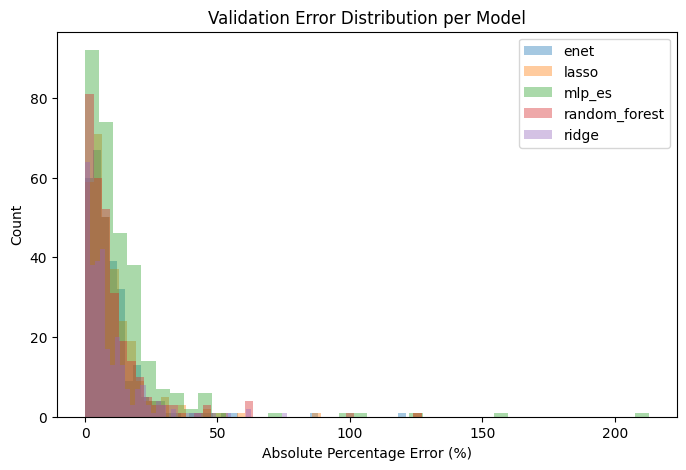

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for name, group in df_all.groupby("model"):
    plt.hist(group["pct_error"] * 100, bins=40, alpha=0.4, label=name)
plt.xlabel("Absolute Percentage Error (%)")
plt.ylabel("Count")
plt.title("Validation Error Distribution per Model")
plt.legend()
plt.show()

Most predictions (for all models) have very low percentage errors (0–10%).

The long “tail” to the right means a few houses were predicted poorly (outliers).